# Задание 
# "Натинуть" сферу на модель из 1 лабы
#  Подобрать параметры для большей схадимости

## Скачивание библиотек в калабе

In [1]:
import os
import sys
import torch
need_pytorch3d=False
try:
    import pytorch3d
    import celluloid
except ModuleNotFoundError:
    need_pytorch3d=True
if need_pytorch3d:
    if torch.__version__.startswith("2.1.") and sys.platform.startswith("linux"):
        # We try to install PyTorch3D via a released wheel.
        pyt_version_str=torch.__version__.split("+")[0].replace(".", "")
        version_str="".join([
            f"py3{sys.version_info.minor}_cu",
            torch.version.cuda.replace(".",""),
            f"_pyt{pyt_version_str}"
        ])
        !pip install fvcore iopath
        !pip install --no-index --no-cache-dir pytorch3d -f https://dl.fbaipublicfiles.com/pytorch3d/packaging/wheels/{version_str}/download.html
        !pip install celluloid
        !pip install trimesh
    else:
        # We try to install PyTorch3D from source.
        !pip install git+https://github.com/facebookresearch/pytorch3d.git@stable
        !pip install celluloid
        !pip install trimesh

## Импорт зависимостей

In [2]:
import matplotlib.pyplot as plt

# You should work in Jupyter.
from tqdm import tqdm_notebook
from IPython.display import Video

from celluloid import Camera

# untilitis
from pytorch3d.utils import ico_sphere

# loss functions and regulaziers
from pytorch3d.loss import (
    chamfer_distance,
    mesh_edge_loss,
    mesh_laplacian_smoothing,
    mesh_normal_consistency
)

# # io utils
from pytorch3d.io import load_obj

# operations with data
from pytorch3d.ops import sample_points_from_meshes

# datastructures
from pytorch3d.structures import Meshes
from pytorch3d.renderer import Textures
# render
from pytorch3d.renderer import (
    look_at_view_transform,
    OpenGLPerspectiveCameras,
    DirectionalLights,
    RasterizationSettings,
    MeshRenderer,
    MeshRasterizer,
    HardPhongShader
)

# If you have got a CUDA device, you can use GPU mode
if torch.cuda.is_available():
  device = torch.device('cuda:0')
  torch.cuda.set_device(device)
else:
  device = torch.device('cpu')

## Загрузка моделей

In [3]:
# Bunny mesh in pytorch3d
verts, faces_idx, _ = load_obj('..\data\Dragon\Dragon.obj')
faces = faces_idx.verts_idx

center = verts.mean(0)
verts = verts - center
scale = max(verts.abs().max(0)[0])
verts = verts / scale

# Initialize each vertex to be white in color.
verts_rgb = torch.ones_like(verts)[None]  # (1, V, 3)

textures = Textures(verts_rgb=verts_rgb.to(device))

# Create a Meshes object for the bunny.
bunny_mesh = Meshes(
    verts=[verts.to(device)],
    faces=[faces.to(device)],
    textures=textures
)

# Sphere mesh in pytorch3d
sphere_mesh = ico_sphere(4, device)
verts_rgb = torch.ones_like(sphere_mesh.verts_list()[0])[None]
sphere_mesh.textures = Textures(verts_rgb=verts_rgb.to(device))

## Подготовка к отрисовки

In [4]:
# Initialize an OpenGL perspective camera.
cameras = OpenGLPerspectiveCameras(device=device)

# We will also create a phong renderer. This is simpler and only needs to render one face per pixel.
raster_settings = RasterizationSettings(
    image_size=1024,
    blur_radius=0,
    faces_per_pixel=1,
)

# We can add a directional light in the scene.
ambient_color = torch.FloatTensor([[0.0, 0.0, 0.0]]).to(device)
diffuse_color = torch.FloatTensor([[1.0, 1.0, 1.0]]).to(device)
specular_color = torch.FloatTensor([[0.1, 0.1, 0.1]]).to(device)
direction = torch.FloatTensor([[1, 1, 1]]).to(device)
lights = DirectionalLights(ambient_color=ambient_color,
                           diffuse_color=diffuse_color,
                           specular_color=specular_color,
                           direction=direction,
                           device=device)

phong_renderer = MeshRenderer(
    rasterizer=MeshRasterizer(
        cameras=cameras,
        raster_settings=raster_settings
    ),
    shader=HardPhongShader(
        device=device,
        cameras=cameras,
        lights=lights
        )
)

# # Select the viewpoint using spherical angles
distance = 5   # distance from camera to the object`
elevation = 30   # angle of elevation in degrees
azimuth = 10  # No rotation so the camera is positioned on the +Z axis.
# # Get the position of the camera based on the spherical angles
R, T = look_at_view_transform(distance, elevation, azimuth, device=device,at=((-0.02,0.1,0.0),))

# # Render the bunny providing the values of R and T.
image_bunny = phong_renderer(meshes_world=bunny_mesh, R=R, T=T)
image_sphere = phong_renderer(meshes_world=sphere_mesh, R=R, T=T)

image_sphere = image_sphere.cpu().numpy()
image_bunny = image_bunny.cpu().numpy()

## Отрисовка моделей

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


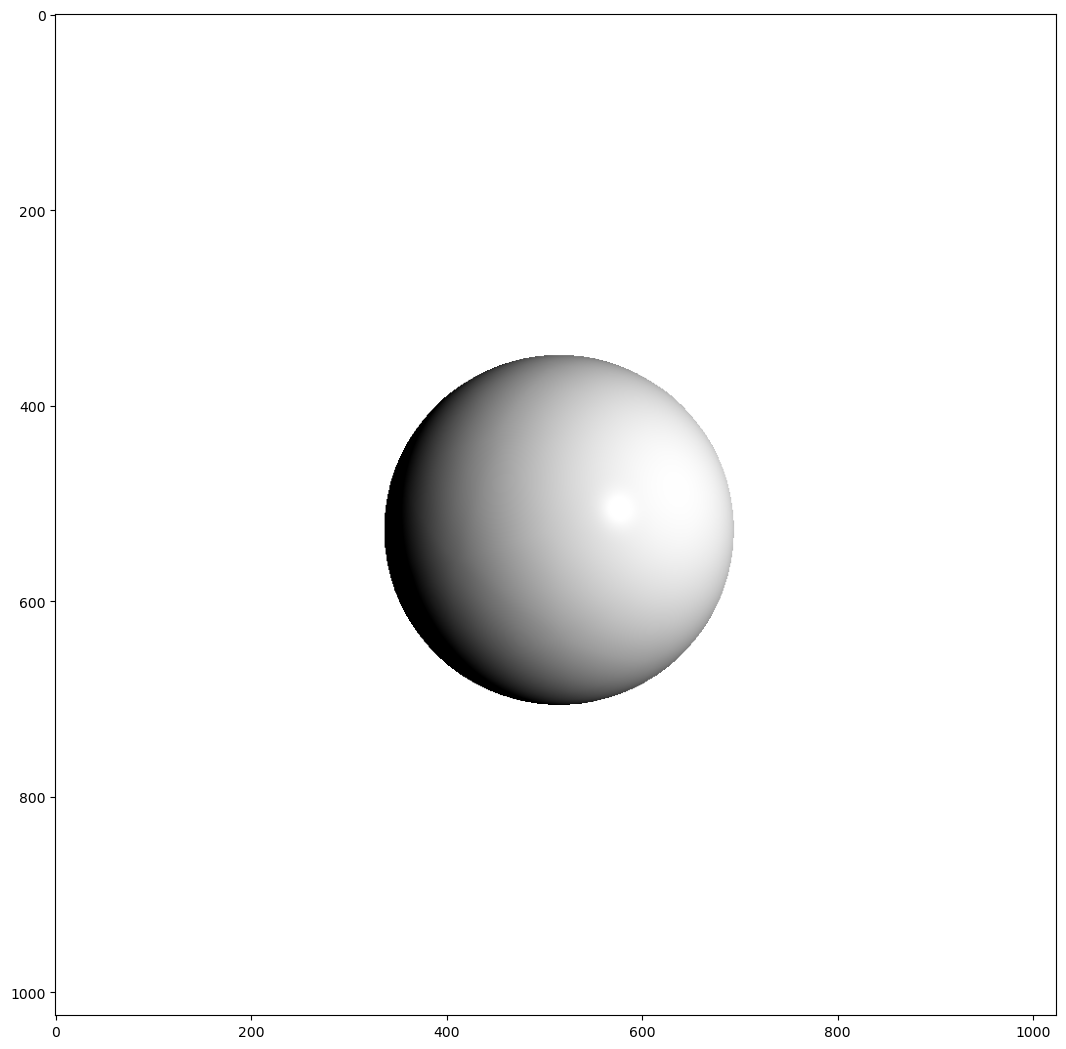

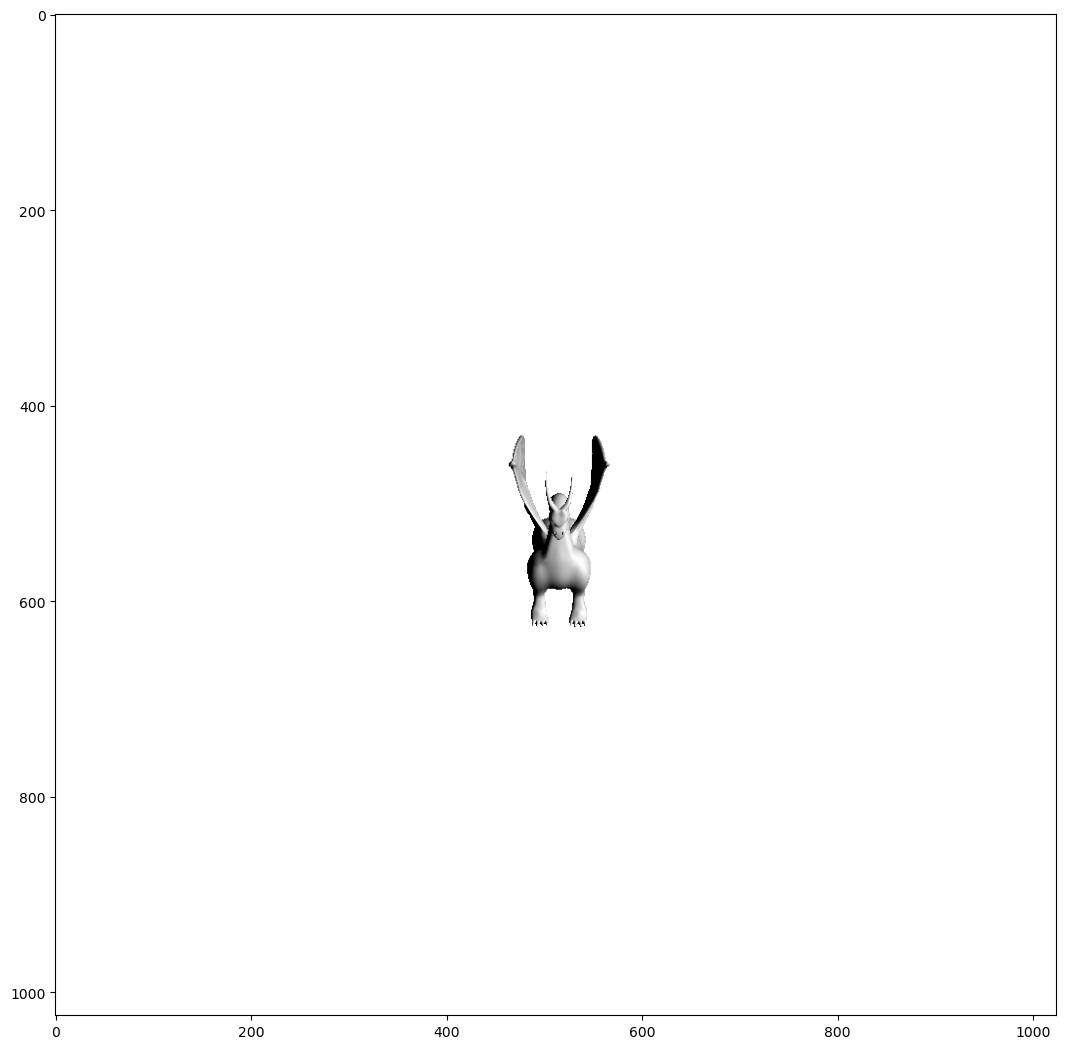

In [5]:
# Source mesh of sphere
plt.figure(figsize=(13, 13))
plt.imshow(image_sphere.squeeze())
plt.grid(False)

# Target mesh of bunny
plt.figure(figsize=(13, 13))
plt.imshow(image_bunny.squeeze())
plt.grid(False)

## Гиперпараметры

In [6]:
# Number of optimization steps
Niter = 3000
# Weight for the chamfer loss
w_chamfer = 1.0
# Weight for mesh edge loss
w_edge = 2.0
# Weight for mesh normal consistency
w_normal = 0.01
# Weight for mesh laplacian smoothing
w_laplacian = 0.1

lr = 0.02
factor=0.5
patience=10

In [7]:
deform_verts = torch.full(sphere_mesh.verts_packed().shape, 0.0, device=device, requires_grad=True)
optimizer = torch.optim.AdamW([deform_verts], lr=lr)
scheduler=torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min',factor=factor,patience=patience)

In [8]:
# Plot period for the losses
plot_period = 50
chamfer_losses = []
laplacian_losses = []
edge_losses = []
normal_losses = []

## Обучение

C:\Users\Павел\AppData\Local\Temp\ipykernel_4984\1795232660.py:1: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  loop = tqdm_notebook(range(Niter))


  0%|          | 0/3000 [00:00<?, ?it/s]

C:\Users\Павел\AppData\Roaming\Python\Python39\site-packages\pytorch3d\ops\laplacian_matrices.py:49: UserWarning: torch.sparse.SparseTensor(indices, values, shape, *, device=) is deprecated.  Please use torch.sparse_coo_tensor(indices, values, shape, dtype=, device=). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:607.)
  A = torch.sparse.FloatTensor(idx, ones, (V, V))
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clip

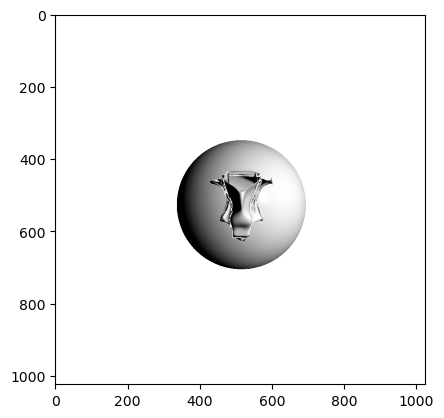

In [9]:
loop = tqdm_notebook(range(Niter))

fig = plt.figure()
camera = Camera(fig)

for i in loop:
    # Initialize optimizer
    optimizer.zero_grad()

    # Deform the mesh
    new_src_mesh = sphere_mesh.offset_verts(deform_verts)

    # We sample 5k points from the surface of each mesh
    sample_trg = sample_points_from_meshes(bunny_mesh, 5000)
    sample_src = sample_points_from_meshes(new_src_mesh, 5000)

    # We compare the two sets of pointclouds by computing (a) the chamfer loss
    loss_chamfer, _ = chamfer_distance(sample_trg, sample_src)

    # and (b) the edge length of the predicted mesh
    loss_edge = mesh_edge_loss(new_src_mesh)

    # mesh normal consistency
    loss_normal = mesh_normal_consistency(new_src_mesh)

    # mesh laplacian smoothing
    loss_laplacian = mesh_laplacian_smoothing(new_src_mesh, method="uniform")

    # Weighted sum of the losses
    loss = loss_chamfer * w_chamfer + loss_edge * w_edge + loss_normal * w_normal + loss_laplacian * w_laplacian

    # Print the losses
    loop.set_description('total_loss = %.6f' % loss)

    # Save the losses for plotting
    chamfer_losses.append(loss_chamfer.cpu().detach().numpy())
    edge_losses.append(loss_edge.cpu().detach().numpy())
    normal_losses.append(loss_normal.cpu().detach().numpy())
    laplacian_losses.append(loss_laplacian.cpu().detach().numpy())

    # Plot mesh
    if i % plot_period == 0 or i==0:

        # Render the bunny providing the values of R and T.
        image_bunny = phong_renderer(meshes_world=new_src_mesh, R=R, T=T)
        image_bunny = image_bunny.detach().cpu().numpy()

        plt.imshow(image_bunny.squeeze())
        plt.grid(False)
        camera.snap()

    # Optimization step
    loss.backward()
    optimizer.step()
    scheduler.step(loss)

## График обучения

Text(0.5, 1.0, 'Loss vs iterations')

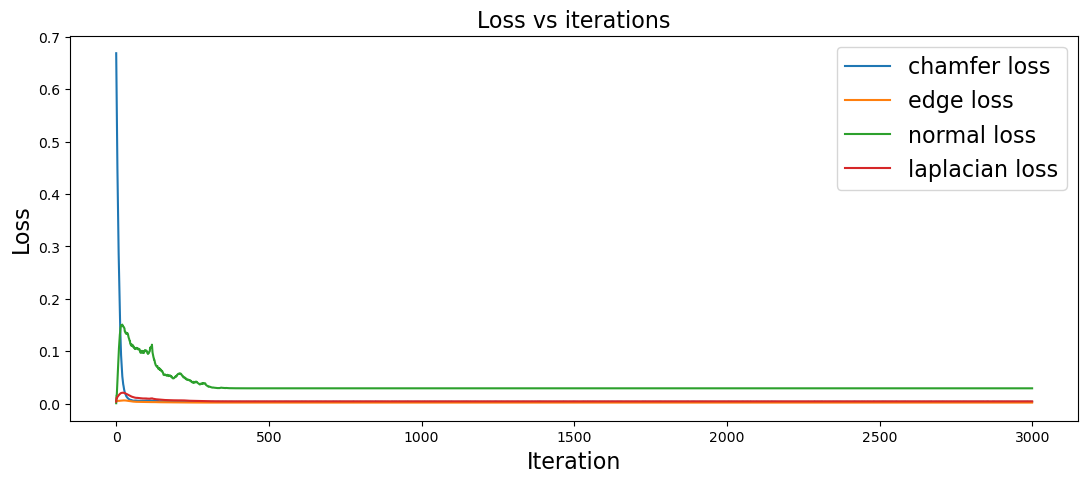

In [10]:
# Losses evaluation
fig = plt.figure(figsize=(13, 5))
ax = fig.gca()
ax.plot(chamfer_losses, label="chamfer loss")
ax.plot(edge_losses, label="edge loss")
ax.plot(normal_losses, label="normal loss")
ax.plot(laplacian_losses, label="laplacian loss")
ax.legend(fontsize="16")
ax.set_xlabel("Iteration", fontsize="16")
ax.set_ylabel("Loss", fontsize="16")
ax.set_title("Loss vs iterations", fontsize="16")

In [15]:
animation = camera.animate()
animation.save('animation.mp4')

MovieWriter ffmpeg unavailable; using Pillow instead.


ValueError: unknown file extension: .mp4